In [1]:
from PIL import ImageFile, UnidentifiedImageError
from IPython import get_ipython
from IPython.display import display
# %%
#!git clone https://github.com/fenads/BairesDev-DIO.git
# %%
%matplotlib inline

import os
import random
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [5]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2025-01-14 19:11:06--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.39.1.112, 2600:1406:4c00:2a6::317f, 2600:1406:4c00:299::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.39.1.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip.1’

kagglecatsanddogs_5 100%[===================>] 786.67M   116MB/s    in 8.3s    

2025-01-14 19:11:14 (94.8 MB/s) - ‘kagglecatsanddogs_5340.zip.1’ saved [824887076/824887076]



In [6]:
# Extraindo todos os arquivos para a pasta atual
import zipfile
with zipfile.ZipFile('/content/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [2]:
# Validando as imagens
import tensorflow as tf

def validate_image(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        return True
    except:
        return False

#dataset_path = '/content/BairesDev-DIO/Dataset-Pragas' #Primeira tentativa
#dataset_path = '/content/DataOxford-iiit-pet' #Segunda tentativa
dataset_path = '/content/PetImages'
valid_files = []
invalid_files = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')) and validate_image(file_path):
            valid_files.append(file_path)
        else:
            invalid_files.append(file_path)
            print(f"Arquivo inválido: {file_path}")

# Deletando os arquivos inválidos
for file_path in invalid_files:
    try:
        os.remove(file_path)
        print(f"Arquivo deletado: {file_path}")
    except OSError as e:
        print(f"Erro ao deletar {file_path}: {e}")

Como já havia usado o dataset de Pragas, e o dataset oxford-iiit-pet e enfrentei problemas de memória no colab devido ao tamanho do dataset, resolvi deixar apenas 100 imagens de cada classe. O número mágico é 100, pelo professor constantemente falar de classes com 100 amostras. E para não incluir nenhum bias, resolvi apagar a imagens randomicamente.

In [6]:
import random

# # Lista de diretórios a serem processados
# diretorios = ["/content/PetImages/Dog", "/content/PetImages/Cat"]

# for diretorio in diretorios:
#     # Listando todos os arquivos no diretório
#     todos_arquivos = os.listdir(diretorio)


# Caminho para o diretório de imagens
diretorio_imagens = "/content/PetImages/Dog"
#diretorio_imagens = "/content/PetImages/Cat"

# Listando todos os arquivos no diretório
todos_arquivos = os.listdir(diretorio_imagens)

# Selecionando aleatoriamente 100 arquivos para manter
arquivos_a_manter = random.sample(todos_arquivos, 100)

# Removendo os arquivos que não foram selecionados
for arquivo in todos_arquivos:
    if arquivo not in arquivos_a_manter:
        #os.remove(os.path.join(diretorio, arquivo))
        os.remove(os.path.join(diretorio_imagens, arquivo))

print(f"Dataset de {diretorio_imagens} reduzido para 100 imagens escolhidas aleatoriamente.")


Dataset de /content/PetImages/Dog reduzido para 100 imagens escolhidas aleatoriamente.


In [7]:
print("arquivos_a_manter")
print(len(arquivos_a_manter))


arquivos_a_manter
100


In [8]:
#root = '/content/BairesDev-DIO/Dataset-Pragas/'
#root = '/content/DataOxford-iiit-pet/'
root = '/content/PetImages/'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']

# Abaixo especifique a taxa de treino e validação
# Exemplo 7% = 0.7 e 15% = 0.15
train_split, val_split = 0.7, 0.15


categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]


print(categories)

['/content/PetImages/Cat', '/content/PetImages/Dog']


In [9]:
def get_image(path):
    try:
        # Tentando abrir e processar a imagem
        img = image.load_img(path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return img, x
    except (UnidentifiedImageError, OSError) as e:
        # Trata a exceção com mensagem de erro e pula o arquivo
        print(f"Error processing image: {path}. Skipping...")
        print(f"Error details: {e}")
        return None, None

In [10]:
from PIL import ImageFile
#antes de chamar o get_image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [11]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        # Checa se a imagem foi carregada com sucesso
        if img is not None and x is not None:
            data.append({'x': np.array(x[0]), 'y': c})
#conta o número de classes
num_classes = len(categories)
print (num_classes)

2


In [12]:
random.shuffle(data)

In [13]:
#calcula o índice onde o conjunto de treinamento termina e o conjunto de validação começa
idx_val = int(train_split * len(data))
#calcula o índice onde o conjunto de validação termina e o conjunto de teste começa
idx_test = int((train_split + val_split) * len(data))
#cria o conjunto de treinamento selecionando amostras do início do conjunto de dados até o índice idx_val
train = data[:idx_val]
#cria o conjunto de validação selecionando amostras do índice idx_valaté o índice idx_test
val = data[idx_val:idx_test]
#cria o conjunto de testes selecionando amostras do índice idx_testaté o final do conjunto de dados.
test = data[idx_test:]

In [14]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0]


In [15]:
print(len(data))
print(len(x_train))
print(len(x_val))
print(len(x_test))

200
140
30
30


In [16]:
# normalizando os dados
x_train = x_train.astype('float32') / 200.
x_val = x_val.astype('float32') / 200.
x_test = x_test.astype('float32') / 200.

# convertendo os labels para one hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(30, 2)


In [17]:
# Sumário
print("Carregadas %d imagens de %d categorias"%(len(data), num_classes))
print("Divisão treino / validacao / teste : %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("Shape dos dados de treino: ", x_train.shape)
print("Shape das categorias de treino: ", y_train.shape)

Carregadas 200 imagens de 2 categorias
Divisão treino / validacao / teste : 140, 30, 30
Shape dos dados de treino:  (140, 224, 224, 3)
Shape das categorias de treino:  (140, 2)


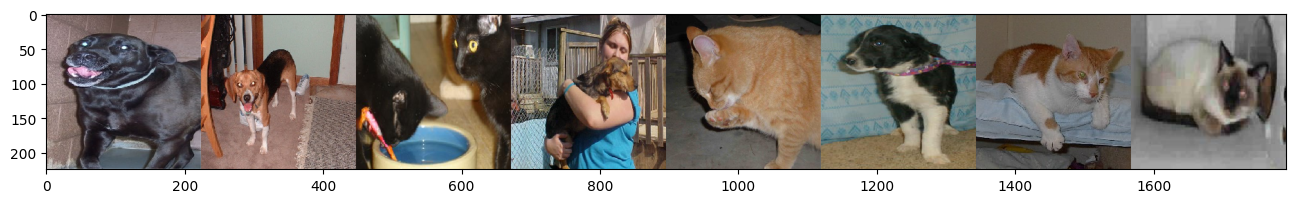

In [18]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

In [19]:
#construindo a rede neural
model = Sequential()
print("Dimensões de entrada: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Dimensões de entrada:  (224, 224, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
#Compilando o modelo (usando função perda cross-entropy catagórica e otimizador adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#Treinando o modelo
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5290 - loss: 0.6953 - val_accuracy: 0.3667 - val_loss: 0.9204
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5221 - loss: 0.9614 - val_accuracy: 0.6333 - val_loss: 0.6759
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4853 - loss: 0.6958 - val_accuracy: 0.6333 - val_loss: 0.6683
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4805 - loss: 0.7163 - val_accuracy: 0.6000 - val_loss: 0.6838
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5832 - loss: 0.6785 - val_accuracy: 0.3667 - val_loss: 0.7087
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5490 - loss: 0.6830 - val_accuracy: 0.3667 - val_loss: 0.7346
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5221 - loss: 0.7051 - val_accuracy: 0.3667 - val_loss: 0.7294
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5143 - loss: 0.7001 - val_accuracy: 0.3667 - val_loss: 0.7160
Epoch 9/

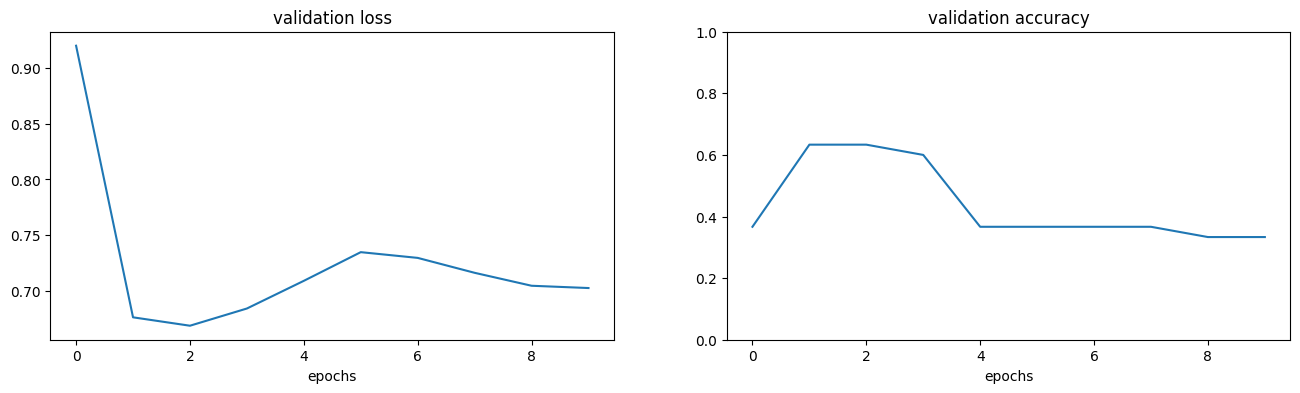

In [21]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [22]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6728459596633911
Test accuracy: 0.6000000238418579


#Iniciando o transfer learning com a rede neural pré-definida

The VGG16 from keras, which was trained on ImageNet and the weights saved online

In [23]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

Congelando os pesos e os biases em todas as camadasda rede neural, exceto a minha nova ao final

In [25]:
#fazendo com que todas as camadas não possam ser treinadas, congelando os pesos (exceto para a última camada)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

#assegurando que a última camada seja treinável/descongelada
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [26]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 109s 30s/step - accuracy: 0.4974 - loss: 1.9298 - val_accuracy: 0.3667 - val_loss: 2.1865
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 103s 25s/step - accuracy: 0.5247 - loss: 1.7387 - val_accuracy: 0.3667 - val_loss: 1.3868
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 139s 26s/step - accuracy: 0.5074 - loss: 1.1274 - val_accuracy: 0.6333 - val_loss: 0.6835
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 151s 28s/step - accuracy: 0.4831 - loss: 0.8806 - val_accuracy: 0.6333 - val_loss: 0.6540
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 134s 23s/step - accuracy: 0.5043 - loss: 0.8074 - val_accuracy: 0.5000 - val_loss: 0.7331
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 149s 26s/step - accuracy: 0.6447 - loss: 0.6084 - val_accuracy: 0.3667 - val_loss: 1.0423
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 101s 24s/step - accuracy: 0.5442 - loss: 0.7435 - val_accuracy: 0.5333 - val_loss: 0.6689
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 140s 25s/step - accuracy: 0.7153 - loss: 0.5258 - val_accuracy: 0.7667 - val_loss:

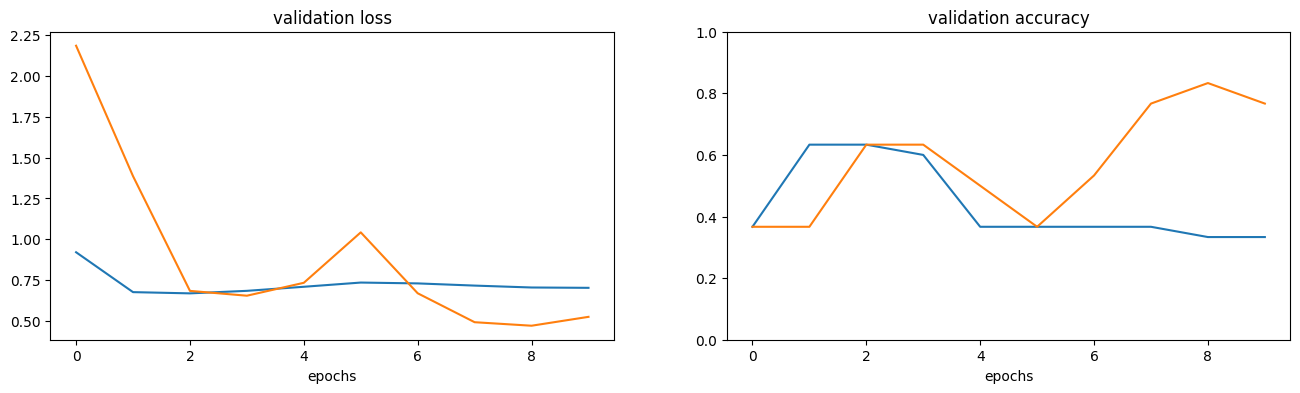

In [27]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [28]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.5314427614212036
Test accuracy: 0.699999988079071


In [29]:
img, x = get_image('/content/beagle_120.jpg')
probabilities = model_new.predict([x])
print(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
[[0.00326852 0.9967315 ]]
